# Early Organogenesis Dataset: Stage E7.25

Below, we analyze separate the E7.25 stage cells of a early organogenesis atlas published by Pijuan-Sala et al. in ["A single-cell molecule map of mouse gastrulation and early organogenesis"](https://www.nature.com/articles/s41586-019-0933-9#Abs1).

We analyze each stage separately to accurately capture the pathway states over time. 

In [1]:
import warnings # ignores annoying warnings that pop up during import of packags
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import scipy as sp
import pandas as pd
import seaborn as sb
from gprofiler import GProfiler

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.font_manager
matplotlib.rcParams['font.family'] = "calibri"
from matplotlib.figure import Figure
from matplotlib.backend_bases import FigureCanvasBase
import matplotlib.ticker as mtick


import module as md

import panel as pn
pn.extension()

from rpy2.robjects import pandas2ri
import anndata2ri
import rpy2.rinterface_lib.callbacks

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# We're going to change some of the parameters for warning/error messages in several packages. 
import logging

# This ignores an annoying matplotlib error that comes up with the colors on a plot.
matplotlib_axes_logger.setLevel('ERROR')

# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Set on Scanpy's verbose output
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()   # print package settings for Scanpy (replicability)
sc.settings.set_figure_params(dpi=80)

# Set directories for the data, results, and figures. SPECIFY AS APPROPRIATE
datadir = '../../data/raw_data/sc_data/early_organogenesis/'
resdir = '../../data/processed_data/sc_data/early_organogenesis/'

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 leidenalg==0.7.0


The whole cell atlas is available at https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6967/.
We separated the dataset prior into different AnnData objects based on cell stage labels in the authors' metadata.

In [3]:
adata = sc.read_h5ad(datadir+"E7.25_post_filtered.h5ad")

adata

AnnData object with n_obs × n_vars = 13537 × 29452
    obs: 'stage', 'batch', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell'
    var: 'n_cells', 'n_cells_per_gene'

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


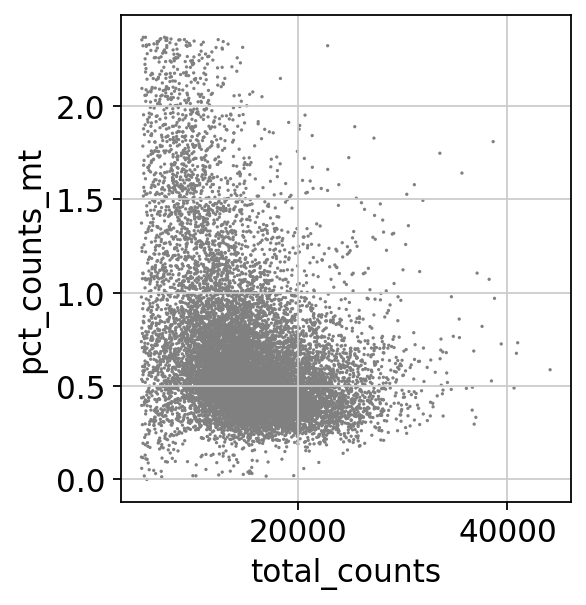

In [4]:
# We can visualize and regress out on the % of mitochondrial genes. 
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

filtered out 227 cells that have less than 2000 genes expressed
filtered out 13734 genes that are detected in less than 13 cells


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


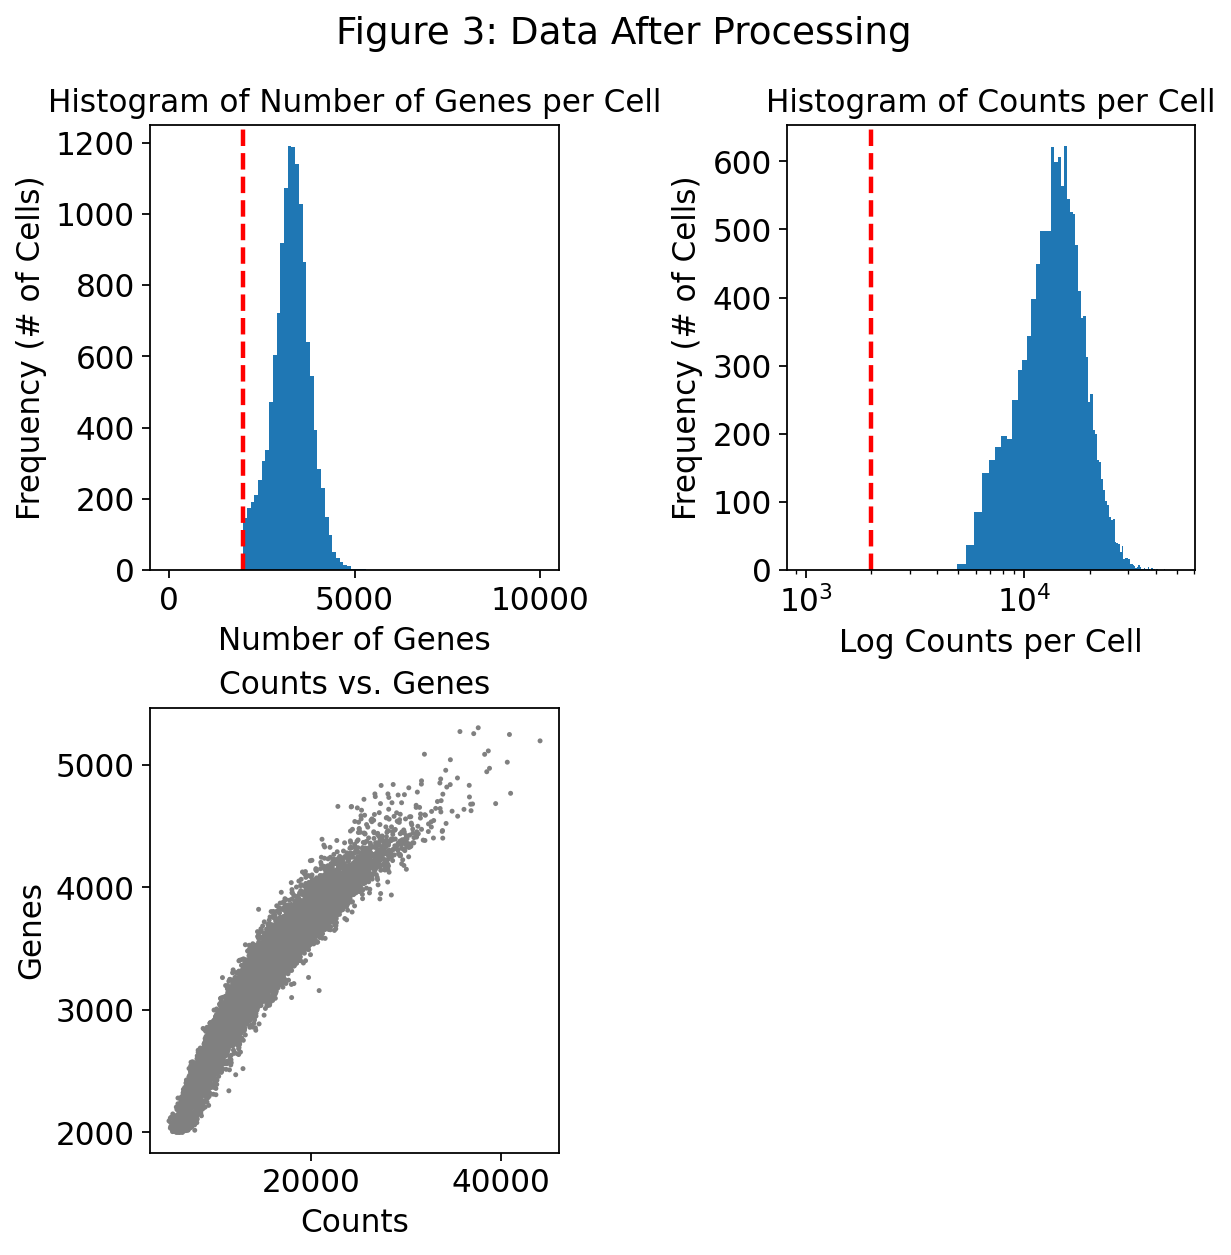

In [5]:
adata = md.filter_data(adata, min_counts=2000, min_genes=2000, min_cells=int(adata.shape[0]*0.001))

post_processing = md.vis_post_processing(adata, genes_range=(0, 10000),
    counts_range=(1e3, 5e4),title='Figure 3: Data After Processing',
                                     genes_threshold = 2000, counts_threshold=2000)

### Data Normalization <a class="anchor" id="3-bullet"></a>

In [6]:
# We save a copy of the AnnData object prior to normalization for differential expression testing.
pre_norm = adata.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# We set the raw attribute of our AnnData object as the normalized count matrix. 
adata.raw=adata

normalizing counts per cell
    finished (0:00:00)


### Highly-Variable Gene Selection <a class="anchor" id="4-bullet"></a>

In [7]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes = 2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Below, we select for genes of interest: Bmp, Wnt, and Notch pathway genes, and marker genes specified in the paper. Note that these genes we select pass our quality-control filters above. Since these genes may not necessarily be highly-variable, we "force" our gene expression matrix to keep our genes of interest for our downstream analysis.

Next, we regress our data on the total number of counts per cell and percentage of counts that are from mitochondrial genes, as He et al. do in their own analysis. We then scale our data set by centering each gene's expression with zero mean and unit variance, and filter out any genes whose standard deviation for expression is greater than 10. 

In [8]:
# get_genes returns a list of genes that are actually in the filtered data matrix (genes that pass the QC filters)
wnt_ligands = md.get_genes(adata, md.wnts)
wnt_receptors = md.get_genes(adata, md.wntr)
bmp_ligands = md.get_genes(adata, md.bmps)
bmp_receptors = md.get_genes(adata, md.bmpr)
notch = md.get_genes(adata, md.notch)
eph_receptors = md.get_genes(adata, md.ephr)
eph_ligands = md.get_genes(adata, md.ephl)
fgfr = md.get_genes(adata, md.fgfr)
splice_srsf = md.get_genes(adata, md.splice_srsf)
lpa = md.get_genes(adata, md.lpa)


# Get this from the paper!
high_exp = ["Gapdh", "Malat1"]
markers = ["Isl1", "Gfpt2", "Tnnt1", "Has2", "Nkx2-3", "Nkx2-5",
          "Kctd12b", "Foxe1", "Bambi", "Cdkn1c", "Phlda2", "Hhex", "Ttr", "Sfrp5",
          "Upp1", "Fzd7", "Osr1", "Ripply3", "Hoxa1", "Irx2", "Fzd2", "Irx1", "Nepn",
          "Nudt11", "Pdzk1ip1", "Hacd4", "Prss8", "B4galt6", "Kitl", "Sct", 
          "Hoxa10", "Cxcl12", "2610528A11Rik", "Tfpi", "Trf", "Xlr3a", "Trap1a",
          "Rhox5", "Cited1", "Cdx1", "Hoxb2", "Zfp503", "Stra6", "Mnx1", "Tlx2",
          "Hoxc9", "Axin2", "Wnt5b", "Smim3", "Cdx2"]

pathways = {'Wnt Ligands': wnt_ligands, 'Wnt Receptors': wnt_receptors, 'BMP Ligands': bmp_ligands,
           'BMP Receptors': bmp_receptors, 'Notch': notch, 'Eph Receptors': eph_receptors, 
           'Eph ligands': eph_ligands, 'Fgfr': fgfr, 'Splice SRSF': splice_srsf,
           'LPA': lpa}

all_genes = [wnt_ligands, wnt_receptors, bmp_ligands, bmp_receptors, notch, high_exp,
            eph_receptors, eph_ligands, fgfr, splice_srsf, lpa]

adata=md.merge_genes(adata, all_genes)
sc.pp.regress_out(adata, ['n_total_counts_per_cell'])
sc.pp.regress_out(adata, ['pct_counts_mt'])
sc.pp.scale(adata)

regressing out ['n_total_counts_per_cell']
    sparse input is densified and may lead to high memory use
    finished (0:00:26)
regressing out ['pct_counts_mt']
    finished (0:00:16)


In [9]:
adata

AnnData object with n_obs × n_vars = 13310 × 2082
    obs: 'stage', 'batch', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'

## Data Visualization <a class="anchor" id="5-bullet"></a>

### Principal component analysis <a class="anchor" id="6-bullet"></a>

We perform principal component analysis on the processed data set. This transforms the data to a new linear space and defines a "best-fitting line" for multi-dimensional data. Below, we also plot the variance ratio of the principal components to determine the minimum number of principal components we must select for dimensionality reduction.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


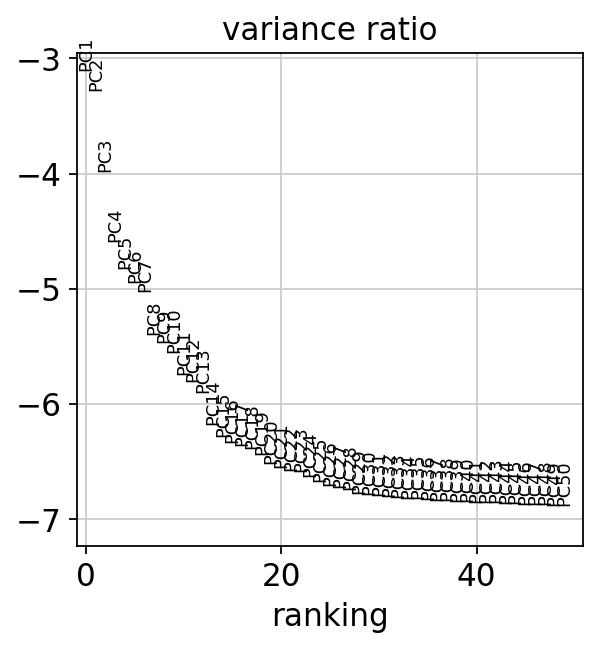

In [10]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

### Computing the Neighborhood Graph and UMAPs <a class="anchor" id="7-bullet"></a>

We can compute a neighborhood graph of cells using a PCA representation of our data matrix. We can then use UMAPs or the Force Atlas algorithm for dimensionality reduction and visualization. We can appropriately adjust the number of principal components we select based on the above variance ratio plot.

In [11]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)

sc.tl.umap(adata, n_components=2)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


### Clustering <a class="anchor" id="8-bullet"></a>

We then want to group the cells based on similarity of gene expression. These smaller clusters can inform us of the heterogeneity within the cell types they make up.

In [12]:
sc.tl.leiden(adata)#, resolution = 5.0)#), resolution=15.0)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


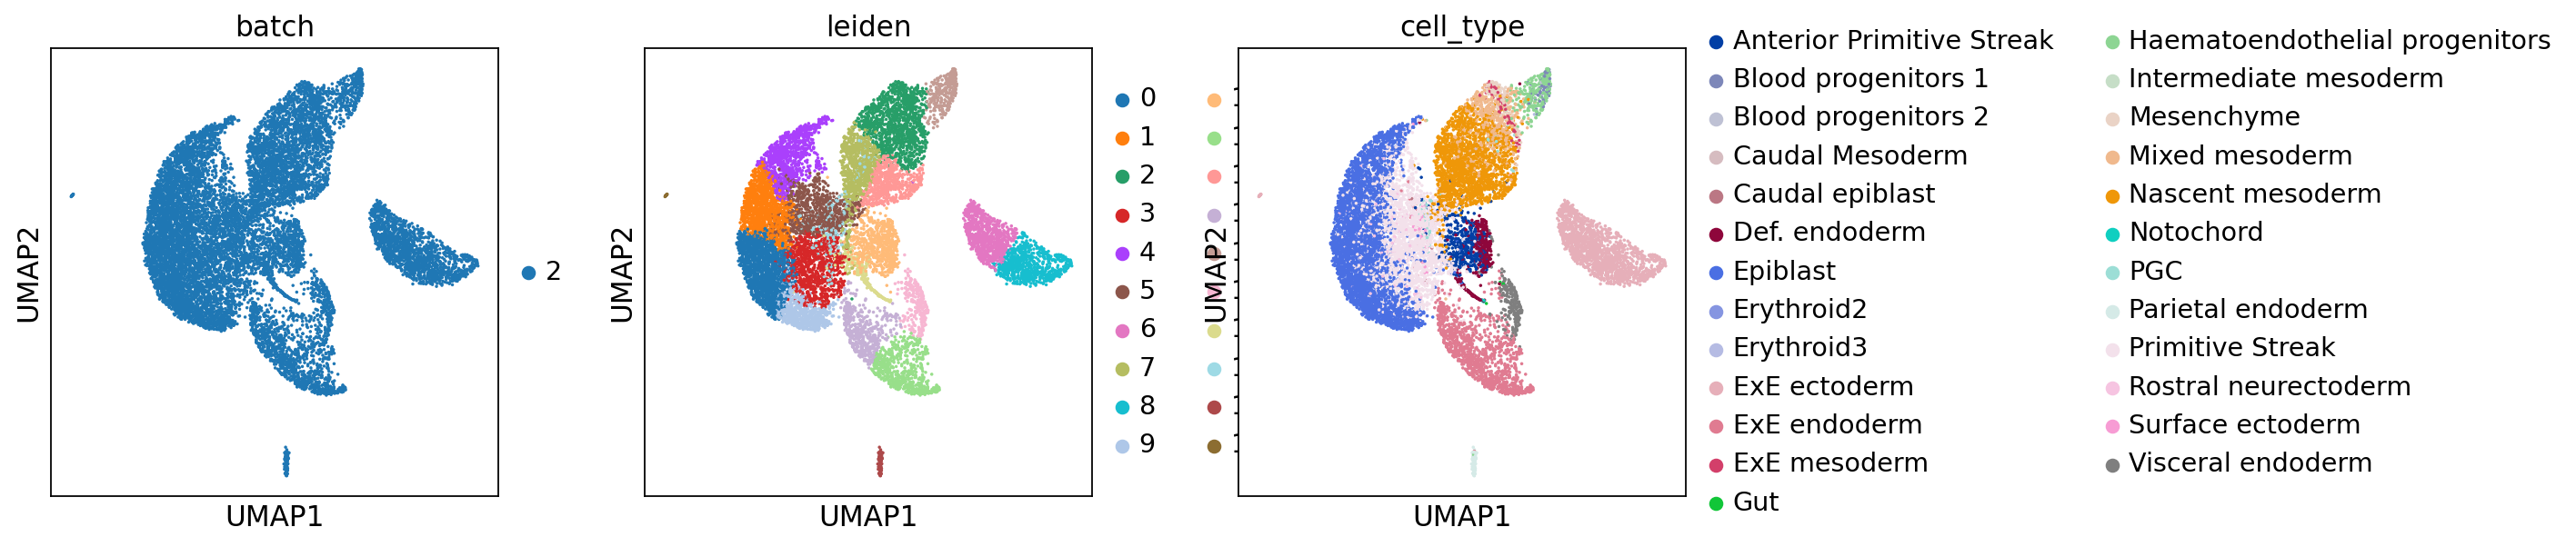

In [13]:
sc.pl.umap(adata, color=["batch", "leiden", "cell_type"], size=10)

In [14]:
# Save individual DataFrames for the forelimb atlas

# Get the Leiden cluster labels for each AnnData object
clusters = list(adata.obs['leiden'].unique())

# Initialize a DataFrame
df = pd.DataFrame(index = clusters, columns = adata.raw.var.index)

# Compute the average expression of all genes for each Leiden cluster
for cluster in clusters:
    df.loc[cluster] = adata[adata.obs['leiden'] == cluster].raw.X.mean(0)

# Add metadata for each Leiden cluster (stage, cell type, tissue, and the # of cells in each cluster)
df["age"] = adata.obs["stage"].unique()[0]
df["cell_ontology_class"] = [adata[adata.obs["leiden"]==i].obs["cell_type"].value_counts().idxmax() for i in df.index]
#df["tissue"] = [adata[adata.obs["leiden"]==i].obs["tissue"].value_counts().idxmax() for i in df.index]
df["num_cells"] = [adata[adata.obs["leiden"]==i].shape[0] for i in df.index]

# Filter cell types only with at least 30 cells
df = df[df["num_cells"] >= 30]

# Save the DataFrame
df.to_csv(resdir + "Marioni_"+ adata.obs["stage"].unique()[0] + "_10x_allgenes.csv")

In [15]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,seaborn,matplotlib,panel,scanpy,anndata2ri,rpy2,jupyterlab

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.17.0

numpy     : 1.18.5
pandas    : 1.1.0
scipy     : 1.5.2
seaborn   : 0.10.1
matplotlib: 3.2.2
panel     : 0.9.7
scanpy    : 1.5.1
anndata2ri: 0.0.0
rpy2      : 3.3.2
jupyterlab: 2.2.4

